In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns
from datetime import datetime

%matplotlib inline

In [2]:
df = pd.read_csv('train.csv')
#test_df = pd.read_csv('test.csv')
print(df.shape)
df.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


<h4>Counting Null Values</h4>

In [3]:
def null_info(data):
    null_df = data.isnull().sum().sort_values(ascending=False).reset_index()
    rows = data.shape[0]
    null_df.columns = ['column_name', 'null_count']
    null_df['null_percentage'] = null_df['null_count']/rows
    return null_df

In [4]:
null_table = null_info(df)
null_table.head()
#list(null_table.column_name)

,column_name,null_count,null_percentage
0,PoolQC,1453,0.995205
1,MiscFeature,1406,0.963014
2,Alley,1369,0.937671
3,Fence,1179,0.807534
4,FireplaceQu,690,0.472603


<h4>Column types and # of unique categorical varibles for categorical columns</h4>

In [5]:
df.dtypes.value_counts()

object     43
int64      35
float64     3
dtype: int64

In [6]:
categorical_unique_counts = df.select_dtypes('object').apply(pd.Series.nunique, axis=0).sort_index()
categorical_unique_counts.sort_values(ascending=False).head()

Neighborhood    25
Exterior2nd     16
Exterior1st     15
SaleType         9
Condition1       9
dtype: int64

In [7]:
categorical_columns = df.select_dtypes(include='object').columns
numerical_columns = df.select_dtypes(exclude='object').columns
target = df['SalePrice']

<h5>Statistic of Target Variable</h5>

In [8]:
df['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

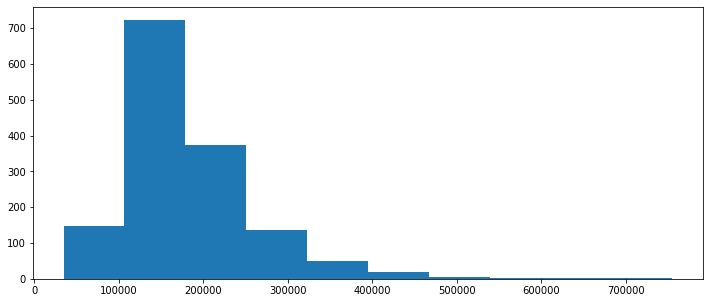

In [9]:
plt.subplots(figsize=(12,5))

plt.hist(df['SalePrice'])
plt.show()

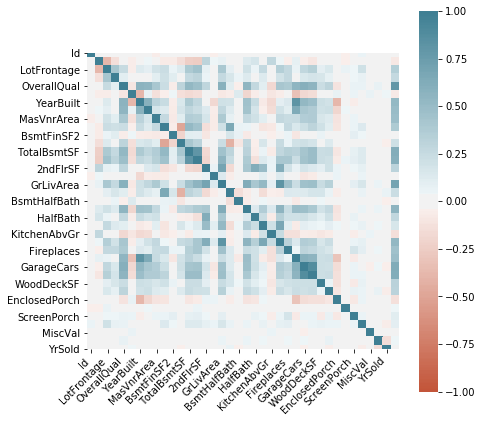

In [10]:
plt.subplots(figsize=(7,7))

correlations = df.corr()

ax = sns.heatmap(
                correlations, 
                vmin=-1, vmax=1, center=0,
                cmap=sns.diverging_palette(20, 220, n=200),
                square=True
            )
ax.set_xticklabels(
                    ax.get_xticklabels(),
                    rotation=45,
                    horizontalalignment='right'
                );

<h5>Handling Null Values</h5>

In [11]:
# dropping columns with more than 15% null values
df2 = df.copy()

cols_to_drop = list(null_table[null_table['null_percentage'] > 0.15]['column_name'])
df2 = df2.drop(cols_to_drop, axis=1)
df2.shape

(1460, 75)

In [12]:
# numerical and categorical columns that are left

categorical_columns = df2.select_dtypes(include='object').columns
numerical_columns = df2.select_dtypes(exclude='object').columns

In [13]:
# filling in null values for categorical_columns with "N/A" values
df2[categorical_columns] = df2[categorical_columns].fillna('NA', axis=1)
df2.head(1)

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500


In [14]:
# filling in null values for numerical columns with the avearge of each column
df2[numerical_columns] = df2[numerical_columns].fillna(df2.mean(axis=0))
df2.head(1)

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500


<h5>Normalizing</h5>

In [15]:
from sklearn.preprocessing import MinMaxScaler

scalar = MinMaxScaler()

df_scaled = scalar.fit_transform(df2[numerical_columns])
df_scaled = pd.DataFrame(df_scaled, columns=numerical_columns)

In [16]:
df2 = pd.concat([df_scaled, df2[categorical_columns]], axis=1)
df2.head()

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,Electrical,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,0.000000,0.235294,0.033420,0.666667,0.500,0.949275,0.883333,0.12250,0.125089,0.0,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
1,0.000685,0.000000,0.038795,0.555556,0.875,0.753623,0.433333,0.00000,0.173281,0.0,...,SBrkr,TA,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
2,0.001371,0.235294,0.046507,0.666667,0.500,0.934783,0.866667,0.10125,0.086109,0.0,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
3,0.002056,0.294118,0.038561,0.666667,0.500,0.311594,0.333333,0.00000,0.038271,0.0,...,SBrkr,Gd,Typ,Detchd,Unf,TA,TA,Y,WD,Abnorml
4,0.002742,0.235294,0.060576,0.777778,0.500,0.927536,0.833333,0.21875,0.116052,0.0,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal


<h5>Splitting to train and test data</h5>

In [17]:
from sklearn.model_selection import train_test_split

train_features = df2.drop(['Id', 'SalePrice'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(train_features, target, test_size=0.25, random_state=0)

In [18]:
X_train.head(1)

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,Electrical,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
1292,0.294118,0.024773,0.444444,0.375,0.144928,0.25,0.0,0.0,0.0,0.425514,...,SBrkr,TA,Min2,Attchd,RFn,TA,TA,Y,WD,Normal


<h5>Using One Hot Encoder for categorical variables</h5>

In [19]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(handle_unknown='ignore', sparse='False')
OH_train_cols = ohe.fit_transform(X_train[categorical_columns])
OH_test_cols = ohe.transform(X_test[categorical_columns])

In [20]:
#OH_train_cols.toarray()
#OH_test_cols.toarray()
#pd.DataFrame(OH_train_cols.toarray()).shape
#pd.DataFrame(OH_test_cols.toarray()).shape
#X_train.drop(obj_columns, axis=1).shape
#X_test.drop(obj_columns, axis=1).shape

In [21]:
encoded_train = pd.DataFrame(OH_train_cols.toarray())
encoded_test = pd.DataFrame(OH_test_cols.toarray())

encoded_train.index = X_train.index
encoded_test.index = X_test.index

num_train = X_train.drop(categorical_columns, axis=1)
num_test = X_test.drop(categorical_columns, axis=1)

OH_train = pd.concat([num_train, encoded_train], axis=1)
OH_test = pd.concat([num_test, encoded_test], axis=1)
OH_train.head()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,230,231,232,233,234,235,236,237,238,239
1292,0.294118,0.024773,0.444444,0.375,0.144928,0.250000,0.000000,0.000000,0.000000,0.425514,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1018,0.352941,0.044329,0.666667,0.500,0.862319,0.700000,0.047500,0.000000,0.000000,0.164384,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1213,0.352941,0.041814,0.333333,1.000,0.673913,0.850000,0.000000,0.114812,0.000000,0.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1430,0.235294,0.096427,0.444444,0.500,0.963768,0.916667,0.000000,0.000000,0.000000,0.313356,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
810,0.000000,0.041319,0.555556,0.625,0.739130,0.816667,0.061875,0.117470,0.255767,0.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [22]:
#OH_train[OH_train.head().isnull() == True]
#OH_train[OH_train.isna().any(axis=1)].iloc[0,10:]
#OH_train.columns[OH_train.isna().any()].tolist()
#list(OH_train['MasVnrArea'])

In [23]:
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import GridSearchCV

start = datetime.now()

reg = SGDRegressor(max_iter=10000)
parameters = {'loss': ['squared_loss', 'huber', 'epsilon_insensitive'],
              'penalty': ['l1', 'l2', 'elasticnet'],
              'alpha': [0.0001, 0.001, 0.01]}

clf = GridSearchCV(reg,
                   param_grid = parameters,
                   scoring = "neg_mean_squared_error")

results = clf.fit(OH_train, y_train)


#printing results
print(f'Best Score: {results.best_score_}')
print(f'Best Parameters: {results.best_params_}')
print(f'Time Take: {datetime.now() - start}')

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:1185: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:1185: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:1185: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/skle

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:1185: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:1185: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:1185: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:1185: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_mo

Best Score: -897906788.5976964
Best Parameters: {'alpha': 0.001, 'loss': 'squared_loss', 'penalty': 'l1'}
Time Take: 0:07:36.444047


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:1185: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


In [40]:
sgd = SGDRegressor(loss='squared_loss', penalty='elasticnet', alpha=0.001)
sgd.fit(OH_train, y_train)

sgd_prediction = sgd.predict(OH_test)
print(f'SGDRegressor RMSE: {np.sqrt(metrics.mean_squared_error(y_test, sgd_prediction))}')

SGDRegressor RMSE: 36843.617972821805


In [113]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=1, solver='svd')

ridge.fit(OH_train, y_train)

ridge_prediction = ridge.predict(OH_test)
print(f'R^2 is: {ridge.score(OH_train, y_train)}', )
print(f'LinearRegression RMSE: {np.sqrt(metrics.mean_squared_error(y_test, ridge_prediction))}')

R^2 is: 0.9339176364529369
LinearRegression RMSE: 41915.68253973415


In [28]:
# first RMSE: 37006
# second RMSE: 36811
# ridge RMSE: 41915

In [29]:
# experiment with more models (neural)
# feature engineer